<a href="https://colab.research.google.com/github/Blueberrylipstick/GymResearch/blob/main/GymResearchAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Presentation
    General requirements:
    - max 15 min + 5 min questions
    - everyone in a group should present at least one topic

## Technology stack:  
    - pyspark or spark SQL (for at least data preprocessing)
    - python (pandas, numpy, sklearn, etc)
    - git - for collaboration
    - Databricks is optional


## Structure:
- Presentation
    - business objectives & problem description
    - how you setup collaboration process in a team

- Technical part (per area: De, Ds, Da)
    - Describe methods, what was done, tell a story with data ...
    - Summary and lessons learned


## Evaluation
    - Presentation / Story telling
    - Data engineering part
    - Data science / analysis part  

In [ ]:
import pandas as pd


In [ ]:
df = pd.read_csv("gym_members_exercise_tracking.csv")

In [ ]:
df

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,24,Male,87.1,1.74,187,158,67,1.57,1364.0,Strength,10.0,3.5,4,3,28.77
969,25,Male,66.6,1.61,184,166,56,1.38,1260.0,Strength,25.0,3.0,2,1,25.69
970,59,Female,60.4,1.76,194,120,53,1.72,929.0,Cardio,18.8,2.7,5,3,19.50
971,32,Male,126.4,1.83,198,146,62,1.10,883.0,HIIT,28.2,2.1,3,2,37.74


# Preprocessing

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("project") \
    .getOrCreate()

In [ ]:
from pyspark.sql.functions import col, when, isnan, count, round
from pyspark.ml.feature import StringIndexer
import pandas as pd

In [ ]:
csv_file_path = "gym_members_exercise_tracking.csv"

df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

df.show()

df.printSchema()

+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+
|Age|Gender|Weight (kg)|Height (m)|Max_BPM|Avg_BPM|Resting_BPM|Session_Duration (hours)|Calories_Burned|Workout_Type|Fat_Percentage|Water_Intake (liters)|Workout_Frequency (days/week)|Experience_Level|  BMI|
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+
| 56|  Male|       88.3|      1.71|    180|    157|         60|                    1.69|         1313.0|        Yoga|          12.6|                  3.5|                            4|               3| 30.2|
| 46|Female|       74.9|      1.53|    179|    151|         66|                     1.3|          883.0|        HIIT|          33.9|                  2.1|              

In [ ]:
nan_counts = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
nan_counts.show()

+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+---+
|Age|Gender|Weight (kg)|Height (m)|Max_BPM|Avg_BPM|Resting_BPM|Session_Duration (hours)|Calories_Burned|Workout_Type|Fat_Percentage|Water_Intake (liters)|Workout_Frequency (days/week)|Experience_Level|BMI|
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+---+
|  0|     0|          0|         0|      0|      0|          0|                       0|              0|           0|             0|                    0|                            0|               0|  0|
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+----------------------

In [ ]:
df = df.withColumn("Gender", when(col("Gender") == "Male", 1).otherwise(0))

df = df.withColumn("Calories_Per_Hour", round(col("Calories_Burned") / col("Session_Duration (hours)"),2))

df = df.withColumn("Activity_Index", round(col("Workout_Frequency (days/week)") * col("Session_Duration (hours)"),2))

In [ ]:
workout_types = ["Yoga", "HIIT", "Cardio", "Strength"]

for workout in workout_types:
    df = df.withColumn(workout, when(col("Workout_Type") == workout, 1).otherwise(0))

In [ ]:
print(type(df))

<class 'pyspark.sql.dataframe.DataFrame'>


In [ ]:
df.coalesce(1).write.option("header", "true").csv("new_gym_members_exercise_tracking.csv")

# EDA

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
df = pd.read_csv('/content/new_gym_members_exercise_tracking.csv/part-00000-b5f50a7f-9014-46b1-9549-ef144bb89313-c000.csv')
df

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,...,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Calories_Per_Hour,Activity_Index,Yoga,HIIT,Cardio,Strength
0,56,1,88.3,1.71,180,157,60,1.69,1313.0,Yoga,...,3.5,4,3,30.20,776.92,6.76,1,0,0,0
1,46,0,74.9,1.53,179,151,66,1.30,883.0,HIIT,...,2.1,4,2,32.00,679.23,5.20,0,1,0,0
2,32,0,68.1,1.66,167,122,54,1.11,677.0,Cardio,...,2.3,4,2,24.71,609.91,4.44,0,0,1,0
3,25,1,53.2,1.70,190,164,56,0.59,532.0,Strength,...,2.1,3,1,18.41,901.69,1.77,0,0,0,1
4,38,1,46.1,1.79,188,158,68,0.64,556.0,Strength,...,2.8,3,1,14.39,868.75,1.92,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,24,1,87.1,1.74,187,158,67,1.57,1364.0,Strength,...,3.5,4,3,28.77,868.79,6.28,0,0,0,1
969,25,1,66.6,1.61,184,166,56,1.38,1260.0,Strength,...,3.0,2,1,25.69,913.04,2.76,0,0,0,1
970,59,0,60.4,1.76,194,120,53,1.72,929.0,Cardio,...,2.7,5,3,19.50,540.12,8.60,0,0,1,0
971,32,1,126.4,1.83,198,146,62,1.10,883.0,HIIT,...,2.1,3,2,37.74,802.73,3.30,0,1,0,0


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('gym_members_exercise_tracking.csv')

In [ ]:
import plotly.express as px

fig = px.histogram(df, x='Age', nbins=5, title='Age Distribution', color='Gender')
fig.update_layout(bargap=0.2)
fig.show()

In [ ]:
fig = px.scatter(df, x='Weight (kg)', y='Height (m)', color='Gender', title='Weight vs Height')
fig.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
sport = pd.read_csv('part-00000-b5f50a7f-9014-46b1-9549-ef144bb89313-c000.csv')

Text(0.5, 1.0, 'Correlation Heatmap')

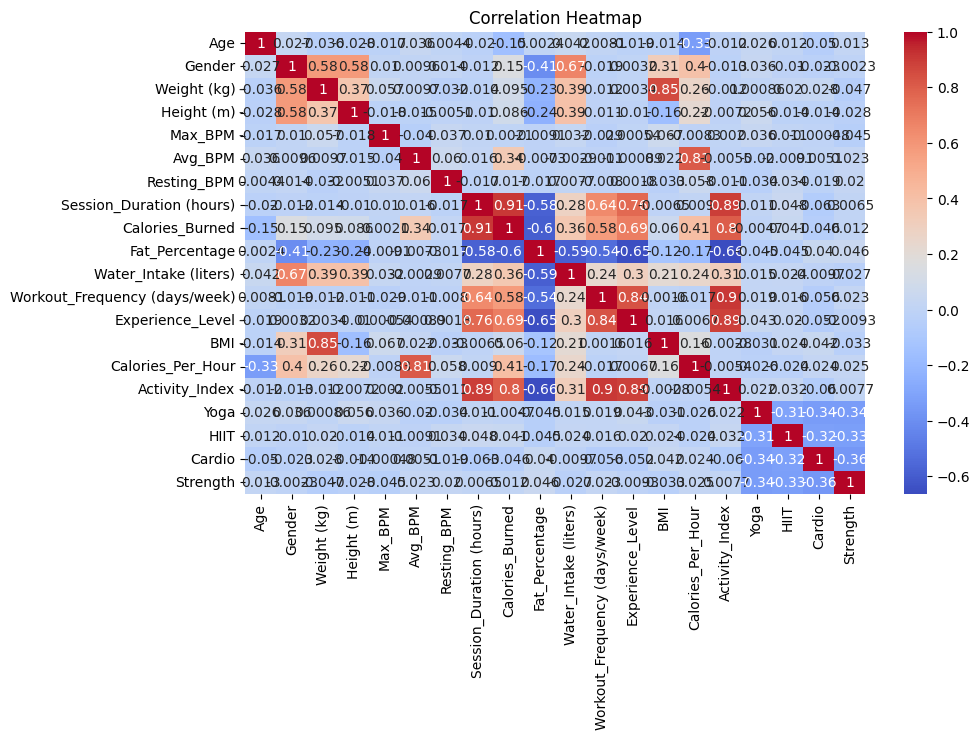

In [ ]:
# correlation heatmap
plt.figure(figsize=(10, 6))
numeric_sport = sport.select_dtypes(include=['number'])
sns.heatmap(numeric_sport.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

In [ ]:
# gender = df.groupby(['gender', 'Age'])
male = sport[sport['Gender'] == 1]
female = sport[sport['Gender'] == 0]

In [ ]:
fig = px.histogram(df, x = 'Workout_Type', title = 'Workout Types Distribution', color='Gender')
fig.show()

In [ ]:
fig = px.histogram(sport, x='Session_Duration (hours)', nbins=10, title='Session duration', color='Gender')
fig.update_layout(bargap=0.2)
fig.show()

In [ ]:
fig = px.scatter(sport, x='Session_Duration (hours)', y='Calories_Burned', title='Calories Burned vs Session Duration')
fig.show()

In [ ]:
import plotly.graph_objects as go

In [ ]:
yoga = sport[sport['Yoga'] == 1]
hiit = sport[sport['HIIT'] == 1]
cardio = sport[sport['Cardio'] == 1]
strength = sport[sport['Strength'] == 1]
fig = px.scatter()
fig.add_trace(go.Scatter(x=yoga['Session_Duration (hours)'], y=yoga['Calories_Burned'], mode='markers', name='Yoga'))
fig.add_trace(go.Scatter(x=hiit['Session_Duration (hours)'], y=hiit['Calories_Burned'], mode='markers', name='HIIT'))
fig.add_trace(go.Scatter(x=cardio['Session_Duration (hours)'], y=cardio['Calories_Burned'], mode='markers', name='Cardio'))
fig.add_trace(go.Scatter(x=strength['Session_Duration (hours)'], y=strength['Calories_Burned'], mode='markers', name='Strength'))
fig.update_layout(title='Calories Burned vs Session Duration by Workout Type')

fig.show()

In [ ]:
fig = px.scatter()
fig.add_trace(go.Scatter(x = sport['Age'], y = sport['Session_Duration (hours)'], mode='markers'))
fig.update_layout(title='Session Duration vs Age')

In [ ]:
fig = px.scatter()
fig.add_trace(go.Scatter(x = sport['Fat_Percentage'], y = sport['Session_Duration (hours)'], mode='markers'))
fig.update_layout(title='Session Duration vs Fat Percentage', xaxis_title='Fat Percentage', yaxis_title='Session Duration')

In [ ]:
fig = px.scatter()
fig.add_trace(go.Scatter(x = male['Fat_Percentage'], y = male['Session_Duration (hours)'], mode='markers'))
fig.add_trace(go.Scatter(x = female['Fat_Percentage'], y = female['Session_Duration (hours)'], mode='markers'))
fig.update_layout(title='Session Duration vs Fat Percentage', xaxis_title='Fat Percentage', yaxis_title='Session Duration')

In [ ]:
fig = px.scatter()
fig.add_trace(go.Scatter(x = sport['Fat_Percentage'], y = sport['Gender'], mode='markers'))
fig.update_layout(title='Gender vs Fat Percentage', xaxis_title='Fat Percentage', yaxis_title='Gender')

In [ ]:
fig = px.box()
fig.add_trace(go.Box(x = sport['Gender'], y = sport['Session_Duration (hours)']))
fig.update_layout(title='Session Duration vs Gendes', xaxis_title='Fat Percentage', yaxis_title='Session Duration')

In [ ]:
fig = px.box()
fig.add_trace(go.Box(x = sport['Experience_Level'], y = sport['Session_Duration (hours)']))
fig.update_layout(title='Session Duration vs Experience Level', xaxis_title='Experience Level', yaxis_title='Session Duration')

In [ ]:
# avg calories burn per workout type
avg_calories = df.groupby('Workout_Type')['Calories_Burned'].mean().reset_index()
fig = px.bar(avg_calories, x='Workout_Type', y='Calories_Burned', title='Average Calories Burned per Workout Type')
fig.show()

In [ ]:
fig = px.histogram(df, 'Workout_Frequency (days/week)', color='Gender')
fig.update_layout(title='Workout Frequency Distribution', bargap=0.2)
fig.show()

In [ ]:
fig = px.histogram(df, 'Workout_Frequency (days/week)', color='Experience_Level')
fig.update_layout(title='Workout Frequency Distribution', bargap=0.2)
fig.show()

# Models

In [ ]:
def rmse(y_true, model, m_name):
  preds = model.predict(X_train)
  res_rmse = np.sqrt(np.mean((preds - y_true) ** 2))
  print(f'{m_name}: {res_rmse}')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

target = 'Calories_Burned'
categorical_features = ['Gender', 'Workout_Type']

label_encoders = {col: LabelEncoder() for col in categorical_features}
for col in categorical_features:
    data[col] = label_encoders[col].fit_transform(df[col])

X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)


NameError: name 'data' is not defined